In [1]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, FloatType
from pyspark.sql import functions as F

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.regression import GeneralizedLinearRegression

import pandas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
sparkSession = SparkSession.builder.appName("Ireland_Climate_data_Analysis").getOrCreate()

Read source file from Hadoop file system

In [3]:
InputFile = "hdfs://hadoop1.example.com:9000/BDA/GlobalLandTemperaturesByCity.csv"
Temperature_Data = sparkSession.read.csv(InputFile,header=True)

Function to filter only Ireland data since 1900 and temperature value is not null

In [4]:
def Filter_Data(df):
    return df.select("dt","AverageTemperature").filter("Country = 'Ireland' and AverageTemperature is not null and dt > '1900-01-00'")

Function to aggregate montly temperature data into average yearly summer(May-Auguest) for every five since 1900

In [5]:
def Aggregate_Data(df):
    df.createOrReplaceTempView("Ireland_Temp_Data")
    return spark.sql("SELECT ceil(CAST(substr(dt,1,4) as INT)/5)*5 as Year, round(avg(AverageTemperature),2) Temperature FROM Ireland_Temp_Data Where substr(dt,7,1) between '5' and '8' Group by ceil(CAST(substr(dt,1,4) as INT)/5)*5  order by Year")

Usng above user defined functions create year(every 5 year) average summary temperature

In [6]:
summer_yearly_avg = Aggregate_Data(Filter_Data(Temperature_Data))

Convert Year column into feature column to make it compatiable with Spark Machine Learning API

In [7]:
Assemble = VectorAssembler(inputCols=["Year"], outputCol="features")

Convert year feature column to 4 dimensions for Polinomial regression

In [8]:
polyExpansion = PolynomialExpansion(degree=4, inputCol="features", outputCol="polyfeatures")

Create Polynomial regression model using Spark ML API GeneralizedLinearRegression with family "tweedie"

In [9]:
polyRegression = GeneralizedLinearRegression(family="tweedie", linkPower=4, labelCol='Temperature',featuresCol='polyfeatures')

Created Pipe line for assemble, poly expansion and model creation

In [10]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[Assemble, polyExpansion, polyRegression])
SparkModel = pipeline.fit(summer_yearly_avg)

Predict temperature for source data using Spark ML Polinomial regression model

In [11]:
pdf = SparkModel.transform(summer_yearly_avg).toPandas()

Store Spark ML Polinomial regression model prections in array glpr for ploting in graph

In [12]:
glrp = pdf['prediction'].values

Store year and temperature data into array x and y to plot it in graph

In [13]:
x = pdf['Year'].values
y = pdf['Temperature'].values

Predict temperature for source data using standard python polynomial regression library and store result

In [14]:
polymodel = np.poly1d(np.polyfit(x, y, 4))
polyp = polymodel(x)

Plot graph with:<br>
Actual temperature data points with red points<br>
Spark ML Polynomial regression result with gren line<br>
Python Polynomial regression result with blue line<br>

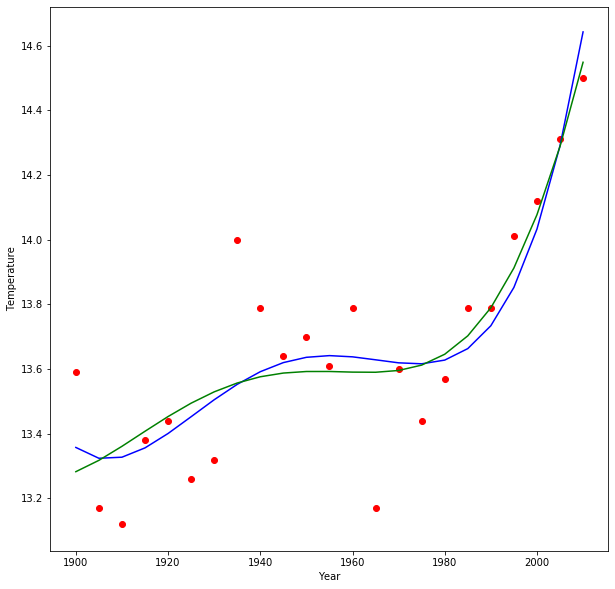

In [15]:
plt.figure(figsize=(10,10))
xp = np.linspace(1900, 2010)

plt.xlabel('Year')
plt.ylabel('Temperature')

plt.scatter(x, y, color='r')

plt.plot(x, polyp, c='b')

plt.plot(x, glrp, c='g')

plt.show()


R2 score of Spark ML regression model

In [16]:
r2_score(y, glrp)

0.7215321564144628

R2 score of standard python poly regression model

In [17]:
r2_score(y, polyp)

0.730108027223213

Predict temperature for futre year(2010 - 2040) using Spark ML Polynomial regression model

In [18]:
futureYears = spark.createDataFrame(list(range(2011, 2041)), IntegerType()).toDF("Year")
fpdf = SparkModel.transform(futureYears).toPandas()

Predict temperature for futre year(2010 - 2040) using standard python poly regression model

In [19]:
xgp = fpdf['prediction'].values
x   = fpdf['Year'].values
xp = polymodel(x)

Plot graph with:<br>
Spark ML Polynomial regression model prediction with gren line<br>
Python Polynomial regression model prediction with blue line

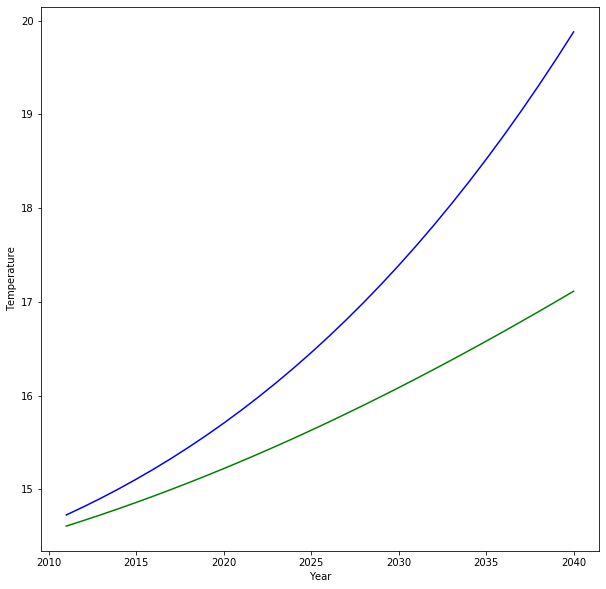

In [20]:
plt.figure(figsize=(10,10))
np.linspace(2010, 2040)

plt.xlabel('Year')
plt.ylabel('Temperature')

plt.plot(x, xp, c='b')

plt.plot(x, xgp, c='g')


plt.show()

Actual average summer temperature of Ireland for 2017-2019

In [21]:
print([14.9,16.05,15.05])

[14.9, 16.05, 15.05]


Prediction of average summer temperature of Ireland for 2017-2019 using Spark ML Polynomial regression model

In [22]:
print(polymodel(list(range(2017, 2020))))

[15.32949681 15.44895027 15.57423036]


Prediction of average summer temperature of Ireland for 2017-2019 using Python Polynomial regression model

In [23]:
a = spark.createDataFrame(list(range(2017, 2020)), IntegerType()).toDF("Year")
SparkModel.transform(a).select('prediction').show()

+------------------+
|        prediction|
+------------------+
|14.997832927972516|
|15.070059365224042|
|15.144257200503416|
+------------------+



Aggregate monthly temperature for every 10 year

In [24]:
decade_avg = spark.sql("SELECT CAST(concat(substr(dt,1,3),'0') as INT) as Year, CAST(substr(dt,6,2) as INT) Month, round(avg(AverageTemperature),2) Temperature FROM Ireland_Temp_Data Group by substr(dt,1,3),substr(dt,6,2) order by Year,Month")

Encapsulate monthly temperatures into collection to easy plot in graph

In [25]:
season_avg = decade_avg.groupBy('Year').agg(F.collect_list('Month').alias('Months'),F.collect_list('Temperature').alias('Temperatures')).orderBy("Year")

Plot temperature throughout the year for all decades in unique color

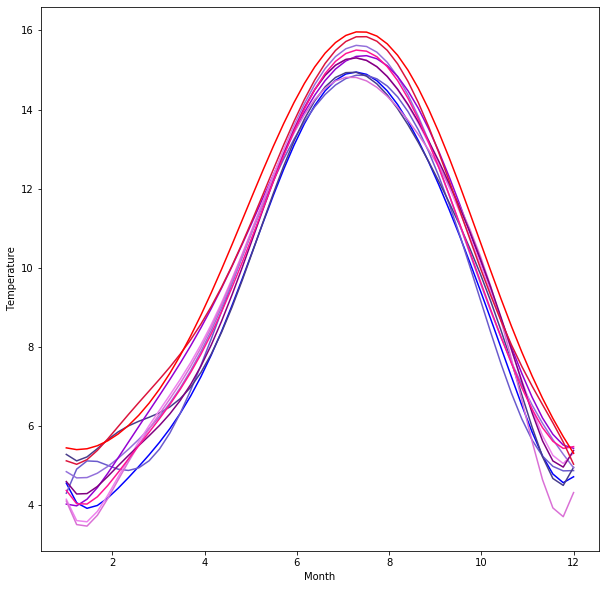

In [26]:
plt.figure(figsize=(10,10))
plt.xlabel('Month')
plt.ylabel('Temperature')
xp = np.linspace(1, 12)
colors=['blue','slateblue','darkslateblue','mediumpurple','darkviolet','violet','orchid','purple','deeppink','crimson','red']

for row in season_avg.rdd.toLocalIterator():
       model2 = np.poly1d(np.polyfit(row.Months, row.Temperatures, 8))
       plt.plot(xp, model2(xp), c=colors[round(row.Year/10)-190])